## Import modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [ ]:
import session_info
session_info.show()

In [ ]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',)

## Function

## Read in data

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult_full_scArches.h5ad')
adata

AnnData object with n_obs × n_vars = 704296 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facilit

In [5]:
genename_column='gene_name-new'

In [6]:
adata.X.data[:10]

array([1., 1., 1., 1., 2., 1., 1., 1., 5., 1.], dtype=float32)

In [7]:
adata.obs['cell_state'].value_counts()

vCM1           97538
nan            75255
PC1_vent       55029
FB1            38691
vCM2           34573
               ...  
gdT               21
NC3_glial         20
NC6_schwann       18
NC4_glial         13
CD4+T_Th17         7
Name: cell_state, Length: 76, dtype: int64

In [8]:
# create celltype - cell state matching dictionary for later step
# ** based on only original dataset **
df = adata.obs[adata.obs['original_or_new']=='original'][['cell_state','cell_type']]
df = df.set_index('cell_type')
df.drop_duplicates(inplace=True)

celltype_states_dict = {}
for celltype in set(df.index):
    if len(df.loc[celltype])>1:
        celltype_states_dict[celltype] = list(df.loc[celltype]['cell_state'])
    elif len(df.loc[celltype])==1:
        celltype_states_dict[celltype] = [df.loc[celltype]['cell_state']]
celltype_states_dict

{'Mural cell': ['SMC2_art',
  'PC2_atria',
  'SMC1_basic',
  'PC1_vent',
  'PC3_str',
  'PC4_CMC-like'],
 'Adipocyte': ['Adip3', 'Adip1', 'Adip4', 'Adip2'],
 'Ventricular Cardiomyocyte': ['vCM4',
  'vCM1',
  'vCM2',
  'vCM3_stressed',
  'vCM5'],
 'Myeloid': ['MoMP',
  'LYVE1+IGF1+MP',
  'CD14+Mo',
  'LYVE1+TIMD4+MP',
  'DC',
  'unclassified',
  'CD16+Mo',
  'LYVE1+MP_cycling',
  'Neut'],
 'Mast cell': ['Mast'],
 'Endothelial cell': ['EC5_art',
  'EC6_ven',
  'EC2_cap',
  'EC4_immune',
  'EC3_cap',
  'EC1_cap',
  'EC7_endocardial',
  'EC10_CMC-like',
  'EC9_FB-like'],
 'Atrial Cardiomyocyte': ['aCM4',
  'aCM1',
  'aCM3',
  'aCM2',
  'aCM5',
  'SAN_P_cell',
  'AVN_bundle_cell',
  'AVN_P_cell'],
 'Lymphoid': ['CD4+T_Th2',
  'MAIT-like',
  'NK_CD16hi',
  'CD8+T_trans',
  'CD8+T_cytox',
  'CD4+T_act',
  'CD8+T_te',
  'CD4+T_naive',
  'T/NK_cycling',
  'B_plasma',
  'NK_CD56hi',
  'B',
  'CD8+T_em',
  'ILC',
  'CD4+T_reg',
  'CD4+T_Th1',
  'gdT',
  'CD4+T_Tfh',
  'CD4+T_Th17'],
 'Fibroblast'

## Modify 'cell_state' column
* original (apart from below): 'cell_state'
* original, SAN/AVN, aCM and vCM: 'cell_state_scNym'<br>
  <- this is to update CCS cell annotations at later steps in this notebook
* new: 'cell_state_scNym' (labels withoug CCS cells)

In [9]:
pd.crosstab(adata.obs['cell_state']=='nan',adata.obs['original_or_new'])

original_or_new,new,original
cell_state,,
False,0,629041
True,75255,0


In [10]:
# get index of new data
new_index = adata.obs_names[adata.obs['original_or_new']=='new']
# add cell state for new data
adata.obs['cell_state'] = adata.obs['cell_state'].astype('str')
adata.obs.loc[new_index,'cell_state'] = adata.obs.loc[new_index,'cell_state_scNym'].copy()
pd.crosstab(adata.obs['cell_state']=='nan',adata.obs['original_or_new'])

original_or_new,new,original
cell_state,,
False,75255,629041


In [11]:
# get index of original SAN/AVN, aCM and vCM
nodesCMs_index = adata.obs_names[(adata.obs['original_or_new']=='original')&\
                                 (adata.obs['region'].isin(['SAN','AVN']))&\
                                 (adata.obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte']))
                                ]
# add cell state
adata.obs['cell_state'] = adata.obs['cell_state'].astype('str')
adata.obs.loc[nodesCMs_index,'cell_state'] = adata.obs.loc[nodesCMs_index,'cell_state_scNym'].copy()
pd.crosstab(adata.obs.loc[nodesCMs_index,'cell_state_scNym'],adata.obs.loc[nodesCMs_index,'region'])

region,AVN,SAN
cell_state_scNym,,
B_plasma,1,0
EC1_cap,2,0
EC2_cap,1,0
EC8_ln,1,0
EC10_CMC-like,5,0
FB2,0,2
FB4,2,0
FB5,1,0
FB6,7,0


In [12]:
pd.crosstab(adata.obs.loc[nodesCMs_index,'cell_type'],adata.obs.loc[nodesCMs_index,'region'])

region,AVN,SAN
cell_type,,
Atrial Cardiomyocyte,561,4883
Ventricular Cardiomyocyte,10703,6


In [13]:
adata.obs.loc[nodesCMs_index]['donor'].value_counts()

A61     15085
AH1      1068
H6          0
AH2         0
AV3         0
AV10        0
AV13        0
AV14        0
D1          0
D2          0
D3          0
H7          0
D5          0
D6          0
D7          0
D8          0
D11         0
H2          0
H3          0
H4          0
H5          0
D4          0
Name: donor, dtype: int64

## Modify AVN-CM 'cell_type' column

since aCM and vCM were re-annotated when subclustered

In [14]:
# before modify
pd.crosstab(adata.obs['region'],adata.obs['cell_type']).T

region,AVN,AX,LA,LV,RA,RV,SAN,SP
cell_type,,,,,,,,
Adipocyte,333,875,1649,203,749,552,1839,147
Atrial Cardiomyocyte,850,5,19509,24,15484,15,9857,62
Endothelial cell,4725,28683,14541,25686,11815,17882,8006,20167
Fibroblast,14674,14676,11672,18704,15026,18706,30176,14421
Lymphatic Endothelial cell,165,238,97,119,33,257,243,143
Lymphoid,1936,3367,3596,3061,3485,2515,3780,3182
Mast cell,142,277,162,450,57,193,270,302
Mesothelial cell,43,8,548,23,293,13,120,9
Mural cell,2809,19853,15316,26942,5160,15766,3711,15036


In [15]:
# read in AVN atrial and ventricular CM annotations
avn_cms = pd.read_csv('/nfs/team205/heart/anndata_objects/8regions/CCS_annotations_full/AVN-CMs_celltype_labels.csv',
                index_col=0)
avn_cms.head()

,cell_type
barcode,
HCAHeartST10773171_HCAHeartST10781448_CATAGACTCAATCTCT-1,Ventricular Cardiomyocyte
HCAHeartST10773171_HCAHeartST10781448_CAGATTCAGCAGCTCA-1,Atrial Cardiomyocyte
HCAHeartST10773171_HCAHeartST10781448_CCATTATTCACATTGA-1,Atrial Cardiomyocyte
HCAHeartST10773171_HCAHeartST10781448_GGTTACCCAAACCTAT-1,Ventricular Cardiomyocyte
HCAHeartST10773171_HCAHeartST10781448_GCAGGAAGTTTAGCGA-1,Atrial Cardiomyocyte


In [16]:
avn_cms['cell_type'].value_counts()

Ventricular Cardiomyocyte    14663
Atrial Cardiomyocyte           955
Name: cell_type, dtype: int64

In [17]:
# reannotate
adata.obs.loc[avn_cms.index[avn_cms['cell_type']=='Atrial Cardiomyocyte'],'cell_type']='Atrial Cardiomyocyte'
adata.obs.loc[avn_cms.index[avn_cms['cell_type']=='Ventricular Cardiomyocyte'],'cell_type']='Ventricular Cardiomyocyte'
# after modify
pd.crosstab(adata.obs['region'],adata.obs['cell_type']).T

region,AVN,AX,LA,LV,RA,RV,SAN,SP
cell_type,,,,,,,,
Adipocyte,333,875,1649,203,749,552,1839,147
Atrial Cardiomyocyte,955,5,19509,24,15484,15,9857,62
Endothelial cell,4725,28683,14541,25686,11815,17882,8006,20167
Fibroblast,14674,14676,11672,18704,15026,18706,30176,14421
Lymphatic Endothelial cell,165,238,97,119,33,257,243,143
Lymphoid,1936,3367,3596,3061,3485,2515,3780,3182
Mast cell,142,277,162,450,57,193,270,302
Mesothelial cell,43,8,548,23,293,13,120,9
Mural cell,2809,19853,15316,26942,5160,15766,3711,15036


## Assign 'unclassified' cells

* Assign as 'unclassified' if the cell_state is not in proper cell_type (refer to celltype_states_dict created above)
* CCS cells assigned as 'unclassified' will be updated with CCS cell annotation in the later steps

In [18]:
# for **new dataset**

for i, celltype in enumerate(celltype_states_dict.keys()):
    print(celltype)
    
    # get cell_state list for the cell type
    cellstates = celltype_states_dict[celltype]
    
    # get obs for the cell type
    # only new dataset or SAN/AVN data (since 'cell_state' of SAN/AVN are replaced with 'cell_state_scNym')
    subset_obs = adata.obs[(adata.obs['cell_type']==celltype)&\
                           ((adata.obs['original_or_new']=='new')|\
                            (adata.obs['region'].isin(['SAN','AVN'])))]
    
    # rename
    renamed_cellstates = ['unclassified' if x not in cellstates else x for x in subset_obs['cell_state']]
    adata.obs.loc[subset_obs.index,'cell_state'] = renamed_cellstates
    
    # generate cell label proportions dataframe
    df = pd.DataFrame(subset_obs['cell_state'].value_counts())
    df = df.apply(lambda x: x/sum(x))
    df.rename(columns={'cell_state':celltype}, inplace=True)
    
    ## drop proper cell states from df
    cellstates_todrop = list(set(cellstates).intersection(df.index))
    df.drop(cellstates_todrop, inplace=True)
    
    ## concatenate
    if i ==0:
        df_all = df.copy()
    else:
        df_all = pd.concat([df_all,df], axis=1)
    
    del cellstates, subset_obs, df, renamed_cellstates, cellstates_todrop

Mural cell
Adipocyte
Ventricular Cardiomyocyte
Myeloid
Mast cell
Endothelial cell
Atrial Cardiomyocyte
Lymphoid
Fibroblast
Lymphatic Endothelial cell
Neuronal cell
Mesothelial cell


<ipython-input-19-5e0589d4f645>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='darkgrey')


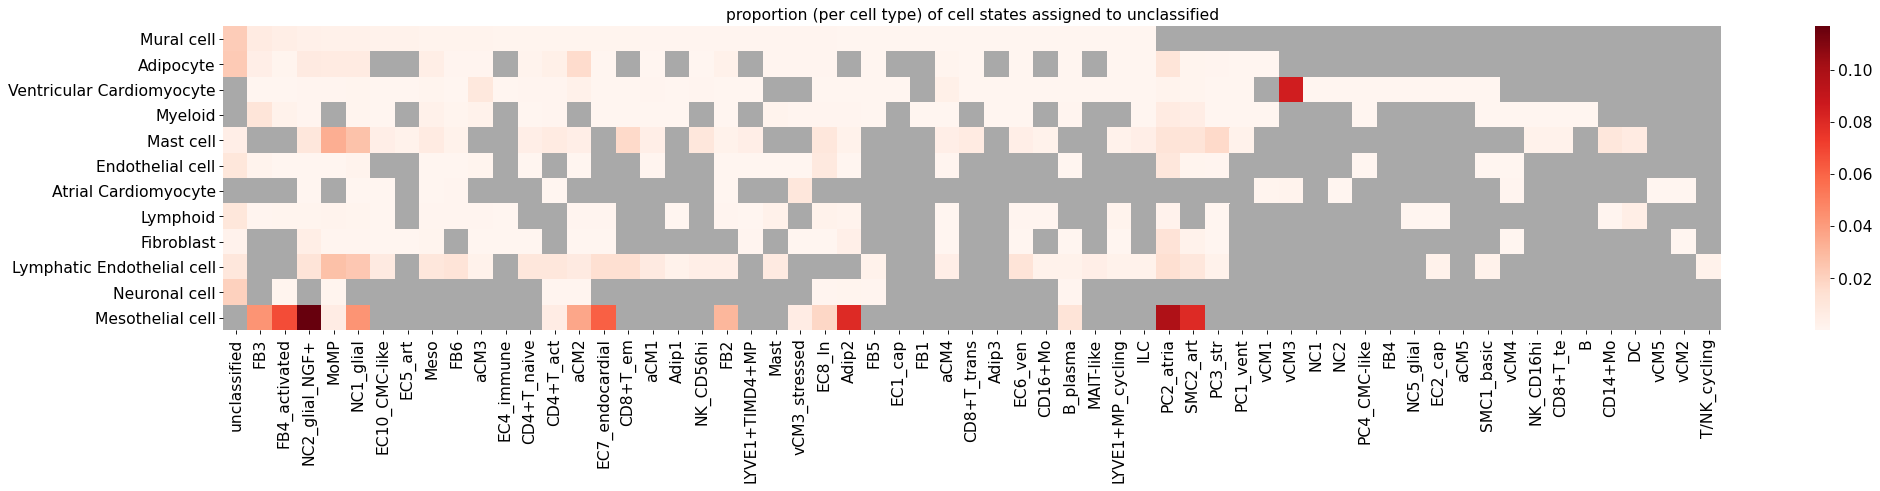

In [19]:
import seaborn as sns
import matplotlib as mpl
plt.rcParams['figure.figsize'] = 30,5
cmap = mpl.cm.get_cmap("Reds")
cmap.set_bad(color='darkgrey')
mask = df_all.T.isnull()
sns.heatmap(df_all.T, mask=mask, cmap=cmap)
plt.title('proportion (per cell type) of cell states assigned to unclassified')
plt.show()

In [20]:
df_all.sum()

Mural cell                    0.069632
Adipocyte                     0.104512
Ventricular Cardiomyocyte     0.117404
Myeloid                       0.043681
Mast cell                     0.252427
Endothelial cell              0.038175
Atrial Cardiomyocyte          0.016186
Lymphoid                      0.039013
Fibroblast                    0.032174
Lymphatic Endothelial cell    0.257353
Neuronal cell                 0.027743
Mesothelial cell              0.705521
dtype: float64

In [21]:
# unclassified number and proportion
# original
obs = adata.obs[adata.obs['original_or_new']=='original']
n_uncl = sum(obs['cell_state']=='unclassified')
print('##### original #####')
print(f'number of unclassified: {n_uncl}')
print(f'proportion of unclassified: {n_uncl/len(obs)}')

# new
obs = adata.obs[adata.obs['original_or_new']=='new']
n_uncl = sum(obs['cell_state']=='unclassified')
print('##### new #####')
print(f'number of unclassified: {n_uncl}')
print(f'proportion of unclassified: {n_uncl/len(obs)}')


##### original #####
number of unclassified: 9782
proportion of unclassified: 0.01555065568063131
##### new #####
number of unclassified: 3979
proportion of unclassified: 0.052873563218390804


In [22]:
# vCMs in RA/LA/SAN -> unclassified
# aCMs in RV/LV/SP/AX -> unclassified

## RA/LA/SAN
print('##### RA/LA/SAN #####')
sub_obs = adata.obs[adata.obs['region'].isin(['RA','LA','SAN'])]
sub_obs = sub_obs[sub_obs['cell_state'].isin(celltype_states_dict['Ventricular Cardiomyocyte'])]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(f'n of cells assigned as unclassified at this step: {len(sub_obs)}')
del sub_obs

## RV/LV/SP/AX
print('##### RV/LV/SP/AX #####')
sub_obs = adata.obs[adata.obs['region'].isin(['RV','LV','SP','AX'])]
sub_obs = sub_obs[sub_obs['cell_state'].isin(celltype_states_dict['Atrial Cardiomyocyte'])]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(f'n of cells assigned as unclassified at this step: {len(sub_obs)}')
del sub_obs

##### RA/LA/SAN #####
n of cells assigned as unclassified at this step: 26
##### RV/LV/SP/AX #####
n of cells assigned as unclassified at this step: 0


## SAN annotation

In [23]:
# checking 
# no CCS cells in the current 'cell_state'
sum(adata.obs['cell_state'].isin(['SAN_P_cell','AVN_P_cell','AVN_bundle_cell']))

0

In [24]:
# add SAN_P_cell annotation
sanP_obsname = list(pd.read_csv('/nfs/team205/heart/anndata_objects/8regions/CCS_annotations_full/SAN-P_index.csv')['barcode'])
print(len(sanP_obsname))

adata.obs.loc[sanP_obsname,'cell_state']='SAN_P_cell'
sum(adata.obs['cell_state']=='SAN_P_cell')

245


245

In [25]:
# 'SAN_P_cell' in non-aCM cell type compartment -> unclassified
# nothing will change theoretically since SAN_P was annotate based on SAN-aCM
# so this is just checking
sub_obs = adata.obs[adata.obs['cell_state']=='SAN_P_cell']
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte'])==False]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(sum(adata.obs['cell_state']=='SAN_P_cell'))
del sub_obs

245


## AVN annotation

AVN CCS cells were annotated as
* Subset AVN, aCM and vCM
* Clustering and reannotate aCM and vCM (already incorporated in adata in the earlier step of this notebook)
* Annotate CCS cells by sub-clustering aCM

In [26]:
# just checking
avn = adata[adata.obs['region']=='AVN']
df = pd.crosstab(avn.obs['cell_type'],avn.obs['cell_state_scNym'])
pd.set_option('display.max_rows', 100)
df.loc[['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'],['aCM1','aCM2','aCM3','aCM4','aCM5','vCM1','vCM2','vCM3_stressed','vCM4','vCM5']].T

cell_type,Atrial Cardiomyocyte,Ventricular Cardiomyocyte
cell_state_scNym,,
aCM1,189,5
aCM2,221,12
aCM3,211,25
aCM4,176,50
aCM5,1,1
vCM1,15,5427
vCM2,1,481
vCM3_stressed,105,2807
vCM4,8,4480


In [27]:
# just checking
avn = adata[adata.obs['region']=='AVN']
df = pd.crosstab(avn.obs['cell_type'],avn.obs['cell_state'])
pd.set_option('display.max_rows', 100)
df.loc[['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'],['aCM1','aCM2','aCM3','aCM4','aCM5','vCM1','vCM2','vCM3_stressed','vCM4','vCM5','unclassified']].T

cell_type,Atrial Cardiomyocyte,Ventricular Cardiomyocyte
cell_state,,
aCM1,189,0
aCM2,221,0
aCM3,211,0
aCM4,176,0
aCM5,1,0
vCM1,0,5427
vCM2,0,481
vCM3_stressed,0,2807
vCM4,0,4480


In [28]:
# add AVN_P_cell annotation
avnP_obsname = list(pd.read_csv('/nfs/team205/heart/anndata_objects/8regions/CCS_annotations_full/AVN-P_index.csv')['barcode'])
print(len(avnP_obsname))

adata.obs.loc[avnP_obsname,'cell_state']='AVN_P_cell'
sum(adata.obs['cell_state']=='AVN_P_cell')

155


155

In [29]:
# add AVN_bundle_cell annotation
avn_bundle_obsname = list(pd.read_csv('/nfs/team205/heart/anndata_objects/8regions/CCS_annotations_full/AVN-bundle_index.csv')['barcode'])
print(len(avn_bundle_obsname))

adata.obs.loc[avn_bundle_obsname,'cell_state']='AVN_bundle_cell'
sum(adata.obs['cell_state']=='AVN_bundle_cell')

38


38

In [30]:
# nothing will change theoretically since SAN_P was annotate based on SAN-aCM
# so this is just checking

# 'AVN_P_cell' in non-aCM|vCN cell type compartment -> unclassified
sub_obs = adata.obs[adata.obs['cell_state']=='AVN_P_cell']
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])==False]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(sum(adata.obs['cell_state']=='AVN_P_cell'))
del sub_obs

# 'AVN_bundle_cell' in non-aCM|vCM cell type compartment -> unclassified
sub_obs = adata.obs[adata.obs['cell_state']=='AVN_bundle_cell']
sub_obs = sub_obs[sub_obs['cell_type'].isin(['Atrial Cardiomyocyte','Ventricular Cardiomyocyte'])==False]
adata.obs.loc[sub_obs.index,'cell_state']='unclassified'
print(sum(adata.obs['cell_state']=='AVN_bundle_cell'))
del sub_obs

155
38


## Purkinje annotation

* AX + AVN -> scVI
* Find a cluster which showed AVN_CCSs enrichment
* Annotate AX cells in the cluster as 'Purkinje_cell'

In [49]:
adata.obs['cell_state'] = adata.obs['cell_state'].astype('str')

# add Purkinje-cell annotation
purkinje_obsname = list(pd.read_csv('/nfs/team205/heart/anndata_objects/8regions/CCS_annotations_full/Purkinje_index.csv')['barcode'])
print(len(purkinje_obsname))

adata.obs.loc[purkinje_obsname,'cell_state']='Purkinje_cell'
sum(adata.obs['cell_state']=='Purkinje_cell')

110


110

## Plotting

In [50]:
adata.obs['cell_type'].cat.categories

Index(['Atrial Cardiomyocyte', 'Ventricular Cardiomyocyte', 'Fibroblast',
       'Endothelial cell', 'Lymphatic Endothelial cell', 'Mural cell',
       'Mesothelial cell', 'Neural cell', 'Adipocyte', 'Myeloid', 'Lymphoid',
       'Mast cell'],
      dtype='object')

In [51]:
# rename cell_type
adata.obs.replace({'cell_type':{
    'Neuronal cell':'Neural cell',
}},inplace=True)


adata.obs['cell_type']=adata.obs['cell_type'].astype('category')
adata.obs['cell_type'].cat.reorder_categories([
   'Atrial Cardiomyocyte', 
    'Ventricular Cardiomyocyte',
    'Fibroblast',
    'Endothelial cell', 
    'Lymphatic Endothelial cell',
    'Mural cell',
    'Mesothelial cell',
     'Neural cell',
    'Adipocyte', 
    'Myeloid',
        'Lymphoid', 
    'Mast cell',
     ], inplace=True)

adata.obs['cell_state']=adata.obs['cell_state'].astype('category')
adata.obs['cell_state'].cat.reorder_categories([
    'SAN_P_cell','AVN_P_cell','AVN_bundle_cell','Purkinje_cell',
    'aCM1','aCM2', 'aCM3', 'aCM4', 'aCM5', 
    'vCM1', 'vCM2','vCM3_stressed', 'vCM4', 'vCM5', 
     'EC1_cap','EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven','EC7_endocardial',
       'EC8_ln', 'EC9_FB-like', 'EC10_CMC-like', 
    'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic', 'SMC2_art',
    'FB1', 'FB2', 'FB3', 'FB4_activated','FB5', 'FB6',
    'Meso',
    'Adip1', 'Adip2', 'Adip3', 'Adip4',
   'NC1_glial','NC2_glial_NGF+', 'NC3_glial', 'NC4_glial', 'NC5_glial','NC6_schwann',
    'CD4+T_naive', 'CD4+T_act','CD4+T_Th1', 'CD4+T_Th2', 'CD4+T_Th17', 'CD4+T_Tfh',
       'CD4+T_reg', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans','MAIT-like','gdT', 
    'NK_CD16hi', 'NK_CD56hi', 'ILC', 
     'B', 'B_plasma', 
    'CD14+Mo',  'CD16+Mo', 'MoMP',
    'LYVE1+IGF1+MP','LYVE1+TIMD4+MP', 'LYVE1+MP_cycling','DC','Neut','Mast',
    'T/NK_cycling', 'unclassified',
     ], inplace=True)

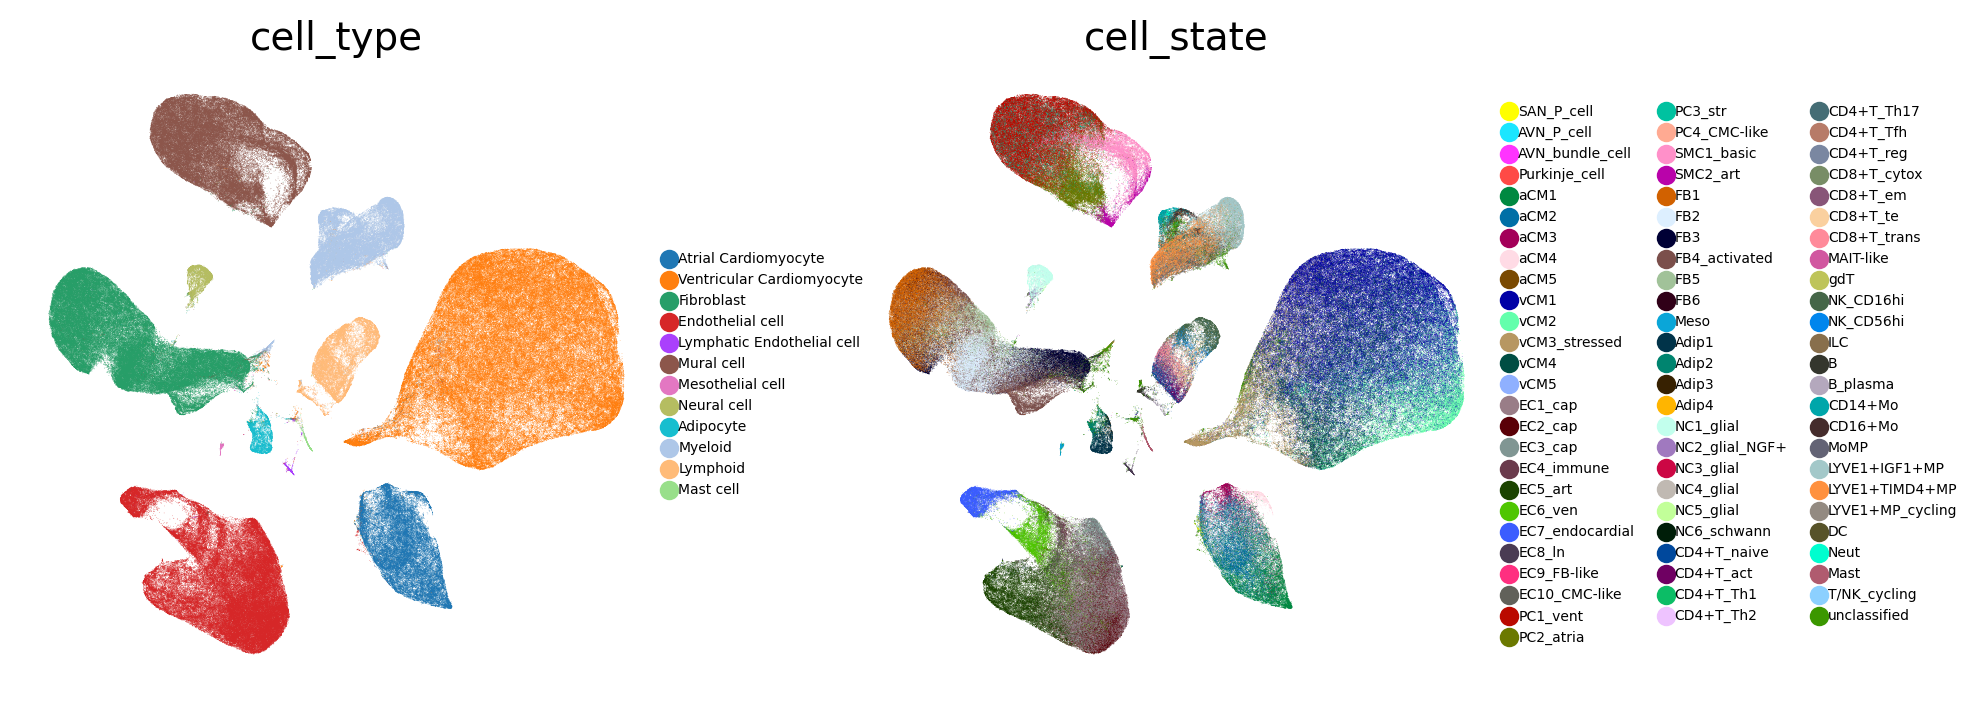

In [52]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(adata, color=['cell_type','cell_state'], legend_fontsize=5, frameon=False,
          # legend_loc='on data', 
          )

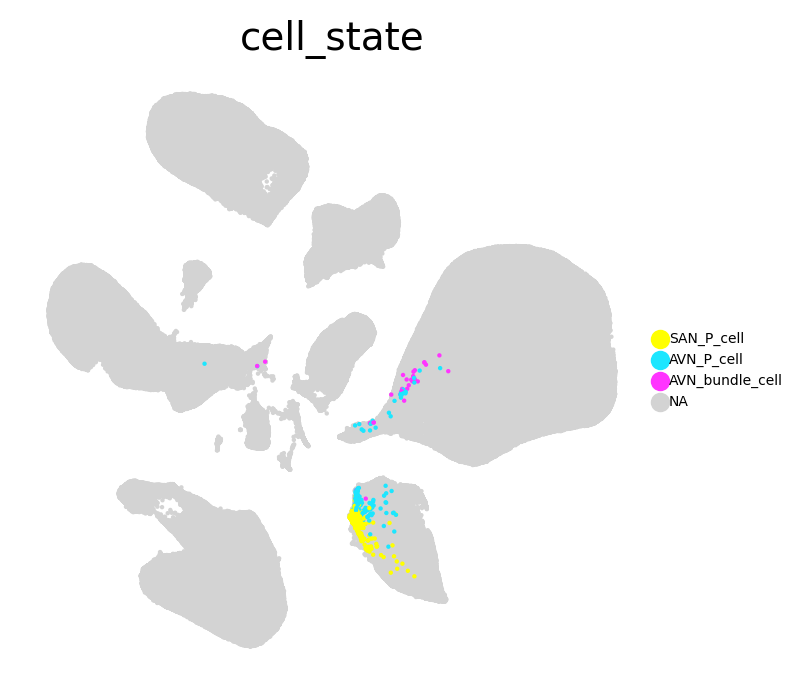

In [53]:
sc.pl.umap(adata, color='cell_state', groups=['SAN_P_cell','AVN_P_cell','AVN_bundle_cell',], legend_fontsize=5, frameon=False,size=10)

In [54]:
adata.X.data[:10]

array([1., 1., 1., 1., 2., 1., 1., 1., 5., 1.], dtype=float32)

## Save

In [55]:
adata.write('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')

In [56]:
adata

AnnData object with n_obs × n_vars = 704296 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_type_colors', 'donor_colors', 'donor_type_colors', 'facilit

In [ ]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')
adata 

In [5]:
# save obs
adata.obs.to_csv('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.obs.csv')

In [6]:
adata.X.data[:10]

array([1., 1., 1., 1., 2., 1., 1., 1., 5., 1.], dtype=float32)

## Checking

In [ ]:
adata

In [38]:
adata.obs[adata.obs['cell_state']=='SAN_P_cell']['donor'].value_counts()

AH1     107
AV3      31
AV14     31
A61      27
AV10     27
AH2      22
H6        0
AV13      0
D1        0
D2        0
D3        0
H7        0
D5        0
D6        0
D7        0
D8        0
D11       0
H2        0
H3        0
H4        0
H5        0
D4        0
Name: donor, dtype: int64

In [39]:
adata.obs[adata.obs['cell_state']=='AVN_P_cell']['donor'].value_counts()

A61     91
AV13    54
AH2     10
H6       0
AH1      0
AV3      0
AV10     0
AV14     0
D1       0
D2       0
D3       0
H7       0
D5       0
D6       0
D7       0
D8       0
D11      0
H2       0
H3       0
H4       0
H5       0
D4       0
Name: donor, dtype: int64

In [40]:
adata.obs[adata.obs['cell_state']=='AVN_bundle_cell']['donor'].value_counts()

A61     26
AH2      6
AV13     5
AH1      1
H6       0
AV3      0
AV10     0
AV14     0
D1       0
D2       0
D3       0
H7       0
D5       0
D6       0
D7       0
D8       0
D11      0
H2       0
H3       0
H4       0
H5       0
D4       0
Name: donor, dtype: int64

In [41]:
adata.obs['modality'].value_counts()

snRNA           357538
Multiome-RNA    211060
scRNA           135698
Name: modality, dtype: int64

In [42]:
adata.obs['kit_10x'].value_counts()

3prime-v3      257029
3prime-v2      236207
Multiome-v1    211060
Name: kit_10x, dtype: int64

In [58]:
adata.obs[adata.obs['cell_state']=='Purkinje_cell']['region'].value_counts()

AX     110
SP       0
SAN      0
RV       0
RA       0
LV       0
LA       0
AVN      0
Name: region, dtype: int64

In [43]:
pd.crosstab(adata.obs['modality'],adata.obs['kit_10x'])

kit_10x,3prime-v2,3prime-v3,Multiome-v1
modality,,,
Multiome-RNA,0,0,211060
scRNA,69166,66532,0
snRNA,167041,190497,0
